# GWFish : Frequency/Time Series

Quick tutorial to show how to use Frequency/Time series within GWFish

Assumes you have already read the [gwfish_tutoial.ipynb](./gwfish_tutorial.ipynb)

### Import packages

In [1]:
from GWFish import detection
from GWFish.modules import utilities as util

import math, h5py
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import astropy.constants as const
from astropy.cosmology import Planck18

/home/ludo/miniconda3/lib/python3.10/site-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


# Analyzing the Frequency Series

To illustrate how to use GWFish to calculate SNR/horizons we will use GW strain available from [here](https://www.astro.princeton.edu/~burrows/gw.3d.new/). You can either manually download those files or execute the next cell to automatically download the file ("23_gwstrain_trim.dat").

In [3]:
import requests
#download from the URL, http
link = "https://www.astro.princeton.edu/~burrows/gw.3d.new/data/"
filename = "23_gwstrain_trim.dat"

response = requests.get(link + filename)

if response.status_code == 200:
    with open(filename, 'wb') as f:
        f.write(response.content)
    print("File downloaded successfully")
else:
    print("Failed to download the file")

File downloaded successfully


We can then look at the downloaded data and its fourier transform. Here we assume that we have a file with 3 columns one for time, h_plus and h_cross.

/tmp/ipykernel_9162/3960507349.py:20: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax2.set_xlim(min(freq_range), max(freq_range))


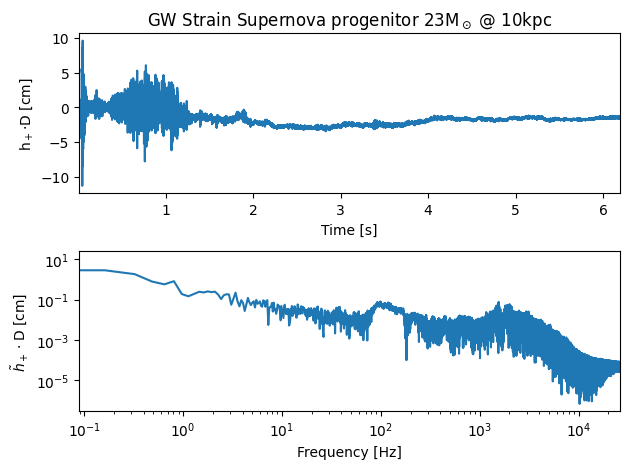

In [2]:
t, hp, hc = np.loadtxt("23_gwstrain_trim.dat").T

fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(t, hp)
ax1.set_ylabel(r"h$_+$$\cdot$D [cm]")
ax1.set_title(r"GW Strain Supernova progenitor 23M$_\odot$ @ 10kpc")
ax1.set_xlim(min(t), max(t))
ax1.set_xlabel("Time [s]")

dt = np.mean(np.diff(t)) #note the time step is not exactly constant but it is fine for this example
df = 1 / (max(t) - min(t)) 
hp_f, freq_range = util.make_fft_from_time_series(hp, df, dt)

ax2.plot(freq_range, abs(hp_f))
ax2.set_ylabel(r"$\tilde{h}_+\cdot$D [cm]")
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel("Frequency [Hz]")
ax2.set_xlim(min(freq_range), max(freq_range))

fig.tight_layout()

We can now proceed to analyze the signal

1. We start by selecting detectors

In [11]:
detector = detection.Detector("ET") #used for the PSD later
detectors = ['ET', 'LHO', 'VIR'] #Justput only one detector in the array if you want to use only one detector
network = detection.Network(detector_ids = detectors)

2. We prepare the signal with proper scaling/units, note that GWFish needs an "augmented" frequency vector (meaning it has an extra axis here denoted by the ```None``` value)

**_NOTE:_** If you already have a frequency series at hand you may skip ```util.make_fft_form_time_series``` step

In [12]:
t, hp, hc = np.loadtxt("23_gwstrain_trim.dat").T

kpc_to_cm = 3.086e21 # cm/kpc
D = 10 * kpc_to_cm

dt = np.mean(np.diff(t)) #the time step is not quite constant for this particular dataset, resampling would be necessary but it gives close enough results to be illustrative
df = 1 / (max(t) - min(t))
hc_f, freq_range   = util.make_fft_from_time_series(hc, df, dt) 
hp_f, _            = util.make_fft_from_time_series(hp, df, dt) 

hc_f_10kpc = hc_f/D
hp_f_10kpc = hp_f/D

f_in = freq_range[:, None]

We also need to selected a certain number of parameters that are needed to evaluate the SNR. The parameter explanation can be found [here](https://gwfish.readthedocs.io/en/latest/reference/parameters_units.html). For a input Frequency series only 3 parameters will affect the SNR. 

In [13]:
params = {
    "ra" : math.radians(200.405),
    "dec" : math.radians(-12.008),
    "psi" : np.pi*0.3,
}

we can also quickly check the detector PSD vs the strains:

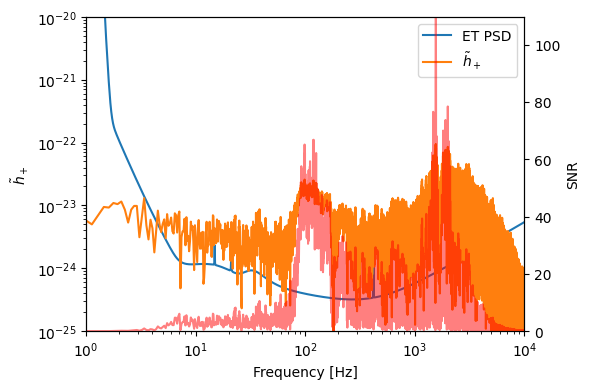

In [14]:
f_et, psd_et = np.loadtxt('GWFish/detector_psd/ET_psd.txt').T

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.plot(f_et, (psd_et)**0.5, label="ET PSD")
ax.plot(freq_range, (freq_range)**0.5*abs(hp_f_10kpc), label=r"$\tilde{h}_+$")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Frequency [Hz]")
ax.set_xlim(min(f_et), max(f_et))
ax.set_ylim([1e-25, 1e-20])
ax.set_ylabel(r"$\tilde{h}_+$")
ax.legend()

#second ax with same x but showing the ration
psd_et_new = detector.components[0].Sn(freq_range) #interpolate the PSD to the freq_range
ax2 = ax.twinx()
ratio_snr = (freq_range)**0.5*abs(hp_f_10kpc) / (psd_et_new)**0.5 
ax2.plot(freq_range, ratio_snr, color='red', label="SNR", alpha=0.5, zorder=-10)
ax2.set_ylabel("SNR")
ax2.set_ylim([0, max(ratio_snr)])

fig.tight_layout()

3. With a prepared Signal we can evaluate an associated SNR

In [15]:
component_SNRs = util.get_SNR_from_strains(f_in, hp_f_10kpc, hc_f_10kpc, network, params)
out_SNR = np.sqrt(np.sum(component_SNRs**2))
print(f"SNR : {out_SNR:.2f}")

SNR : 76.26


# What about Reshift ?

For signals far enough away we need to take into account also the shift in frequency in frequency, obviously for this specific signal (CC-SN) the considered distances are usually ``` D < 1 Mpc ``` so redshift effects are negligible. But for completeness the procedure is as follows :

In [16]:
from astropy.coordinates import Distance
from astropy import units as u

redshift = Distance(10, u.kpc).z #get redshift at the distance we care for

f_in = freq_range[:, None] / (1+redshift) #redshift the frequency, the signal in itself should not change just shift

component_SNRs = util.get_SNR_from_strains(f_in, hp_f_10kpc, hc_f_10kpc, network, params)
out_SNR = np.sqrt(np.sum(component_SNRs**2))
print(f"SNR : {out_SNR:.2f}")

SNR : 76.26


Clearly at 10 kpc we do not see any significant redshift. So we can do a quick check for (slightly) higher redshifts 

In [9]:
redshift = Distance(20, u.Mpc).z #get redshift at the distance we care for

kpc_10_to_20_mpc = 2000

hp_f_20Mpc = hp_f_10kpc / kpc_10_to_20_mpc
hc_f_20Mpc = hc_f_10kpc / kpc_10_to_20_mpc

f_in_noz = freq_range[:, None]
f_in_z = freq_range[:, None] / (1+redshift)

component_SNRs_noz = util.get_SNR_from_strains(f_in_noz, hp_f_20Mpc, hc_f_20Mpc, network, params)
component_SNRs_z = util.get_SNR_from_strains(f_in_z, hp_f_20Mpc, hc_f_20Mpc, network, params)

out_SNR_noz = np.sqrt(np.sum(component_SNRs_noz**2))
out_SNR_z = np.sqrt(np.sum(component_SNRs_z**2))

print(f"Redshift @ 20 Mpc : {redshift:.2e}")
print(f"SNR no z : {out_SNR_noz:.3e}")
print(f"SNR z : {out_SNR_z:.3e}")
print(f"SNR ratio : {out_SNR_noz/out_SNR_z:.5f}")

Redshift @ 20 Mpc : 4.50e-03 redshift
SNR no z : 3.813e-02
SNR z : 3.809e-02
SNR ratio : 1.00119


# What about high frequencies ?

GWFish mainly works under the long waveform approximation. However, this can be turned off for a more accurate SNR determination:

**_NOTE:_** explicitly remove f = 0 (if your signal includes it) as without the approximation there are 1/f terms that diverge. 

In [10]:
f_in = freq_range[:, None]

f_max = 0
condition = freq_range > f_max

f_masked = freq_range[condition][:, None]
hp_f_masked = hp_f_10kpc[condition]
hc_f_masked = hc_f_10kpc[condition]

component_SNRs = util.get_SNR_from_strains(f_masked, hp_f_masked, hc_f_masked, network, params, long_wavelength_approx=False)
out_SNR = np.sqrt(np.sum(component_SNRs**2))
print(f"SNR : {out_SNR:.2f}")

SNR : 75.58
